# Texas COVID-19 data exploration using Pandas (1 of 2)

Primary module objectives:
- Understand what data we are using for this COVID-19 study
- Use Pandas to read data with missing or corrupt entries, and inconsistent headings
- Use Pandas to process the data into a more manageable form and save it for later processing

## Data sources

Primary data sources include the following.

### Texas Department of State Health Services
- Data over time per county: cases, fatalities, estimated active cases, cumulative tests
- COVID-19 hospitalizations and hospital capacity by Trauma Service Area (TSA)
- https://dshs.texas.gov/coronavirus/additionaldata.aspx

### New York Times data collection
- U.S. data, state-level data, and county level data
- cumulative datas, cases, and deaths
- https://github.com/nytimes/covid-19-data

Right now we will use static datasets. Perhaps at a later time we will pull current data directly from the web. Data was pulled on 2020-08-04 from Texas Department of State and Health Services. 

In [34]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib notebook

# update plot defaults:
plt.rcParams.update(
    {"font.size": 16, 
     "figure.figsize": (10,6),
    "lines.linewidth": 3})

# Texas COVID-19 testing data

First, let's take a look at what the spreadsheet holds: 

"Cumulative Tests over Time by County.xlsx"

- First column contains Texas county names
- Headers represent 'test through' date
- The last 5-10 rows contain notes about various aspects of the data
- The last two rows of numerical data are not county numbers, but represent "Pending assignments" and "TOTAL" 

A couple of things pop out that will cause trouble to anyone hoping to analyze this data in any environment:
- Some cells contain special characters (example: row 2, column P)
- The numerical data is not homogeneous; some columns or entries contain strings (example: column P, column AH)

There are lots of ways an analyst could read this data and process it to suit their needs. But not all of those ways will be:
- Easy
- Scalable
- Sharable
- Understandable to others

Pandas is one way to analyze datasets of this sort that satisfactorily meets those three adjectives. 

## Initial data read

We can immediately read this data in with Pandas' read_excel() function. The read_excel() function also contains a lot of keyword arguments we can use to make things easier right off the bat. 

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

- It makes sense for our data to be indexed by County, so let's tell pandas to do that
- We want to skip the first row since it is just a human-readable note, not actual data
- We don't care about the file's bottom notes, and the number of Texas counties will always be the same, so let's hardcode in a number of rows to read.
- We want to treat any strings in the data specially 

In [35]:
# read the data as is:
df = pd.read_excel(
    "data/Cumulative Tests over Time by County.xlsx",
    index_col=[0], #index data by first column
    skiprows=[0], #ignore first row
    nrows=254, #ignore data in rows past row 254
    na_values=["--", "-"] #treat these strings as NaN's
) 

In [36]:
df.head()

,Tests Through April 21,Tests Through April 22,Tests Through April 23,Tests Through April 24,Tests Through April 25,Tests Through April 26,Tests Through April 27,Tests Through April 28,Tests Through April 29,Tests Through April 30,...,Tests Through July 24,Tests Through July 25,Tests Through July 26,Tests Through July 27,Tests Through July 28,Tests Through July 29,Tests Through July 30,Tests Through July 31,Tests Through August 1,Tests Through August 2
County,,,,,,,,,,,,,,,,,,,,,
Anderson,270,282,297,329,337,337,360,360,397,416,...,15983,16032,16055,16060,16061,16544,17593,19903,20612,20740
Andrews,2,2,5,6,6,6,6,6,6,6,...,394,400,401,411,415,416,419,421,431,436
Angelina,282,311,431,434,469,468,544,552,626,667,...,7077,7223,7332,7430,7432,7624,8048,8698,8830,9092
Aransas,16,17,15,24,27,27,27,27,28,29,...,655,664,666,671,671,675,683,690,720,731
Archer,8,9,13,18,20,20,20,20,20,21,...,131,132,133,135,135,137,144,156,161,165


This data is already usable. For example, let's see the number of tests completed in Harris County as of today (which to the author is August 2). 

In [37]:
# df.loc[COUNTY_NAME, THRU_DATE]
df.loc["Harris", "Tests Through August 2"]

534419

## Format the data into a more usable form

Let's do the following to make this data much easier to use, and much more understable to the scientific user:
1. Replace the "test through" columns with standard format dates
2. Replace the strings with NaN (not a number) values so that we don't have to worry about issues when performing calculations, or when plotting

## 1: Format the column names

In [38]:
original_columns = df.columns
original_columns

Index(['Tests Through April 21', 'Tests Through April 22',
       'Tests Through April 23', 'Tests Through April 24',
       'Tests Through April 25', 'Tests Through April 26',
       'Tests Through April 27', 'Tests Through April 28',
       'Tests Through April 29', 'Tests Through April 30',
       ...
       'Tests Through July 24', 'Tests Through July 25',
       'Tests Through July 26', 'Tests Through July 27',
       'Tests Through July 28', 'Tests Through July 29',
       'Tests Through July 30', 'Tests Through July 31',
       'Tests Through August 1', 'Tests Through August 2'],
      dtype='object', length=104)

In [39]:
new_cols = []
for col in original_columns:
    
    # keep only the month and the day:
    coli = col.split("Through ")[-1]
    
    # add the year:
    coli = "%s 2020" %coli
    
    # remove any special characters that might be present:
    coli = coli.replace("*", "")
    
    # process the strings into date objects:
    coli = datetime.strptime(coli, "%B %d %Y")
    
    # keep the intermediate column:
    new_cols.append(coli)

# replace the dataframe columns with the new processed columns:
df.columns = new_cols
df.head()

,2020-04-21,2020-04-22,2020-04-23,2020-04-24,2020-04-25,2020-04-26,2020-04-27,2020-04-28,2020-04-29,2020-04-30,...,2020-07-24,2020-07-25,2020-07-26,2020-07-27,2020-07-28,2020-07-29,2020-07-30,2020-07-31,2020-08-01,2020-08-02
County,,,,,,,,,,,,,,,,,,,,,
Anderson,270,282,297,329,337,337,360,360,397,416,...,15983,16032,16055,16060,16061,16544,17593,19903,20612,20740
Andrews,2,2,5,6,6,6,6,6,6,6,...,394,400,401,411,415,416,419,421,431,436
Angelina,282,311,431,434,469,468,544,552,626,667,...,7077,7223,7332,7430,7432,7624,8048,8698,8830,9092
Aransas,16,17,15,24,27,27,27,27,28,29,...,655,664,666,671,671,675,683,690,720,731
Archer,8,9,13,18,20,20,20,20,20,21,...,131,132,133,135,135,137,144,156,161,165


Now we can access cumulative test values in a more standardized way.

In [40]:
df.loc["Harris", "2020-08-02"]

534419.0

# Plots! 
Let's plot this dataframe itself and see what happens.

<IPython.core.display.Javascript object>


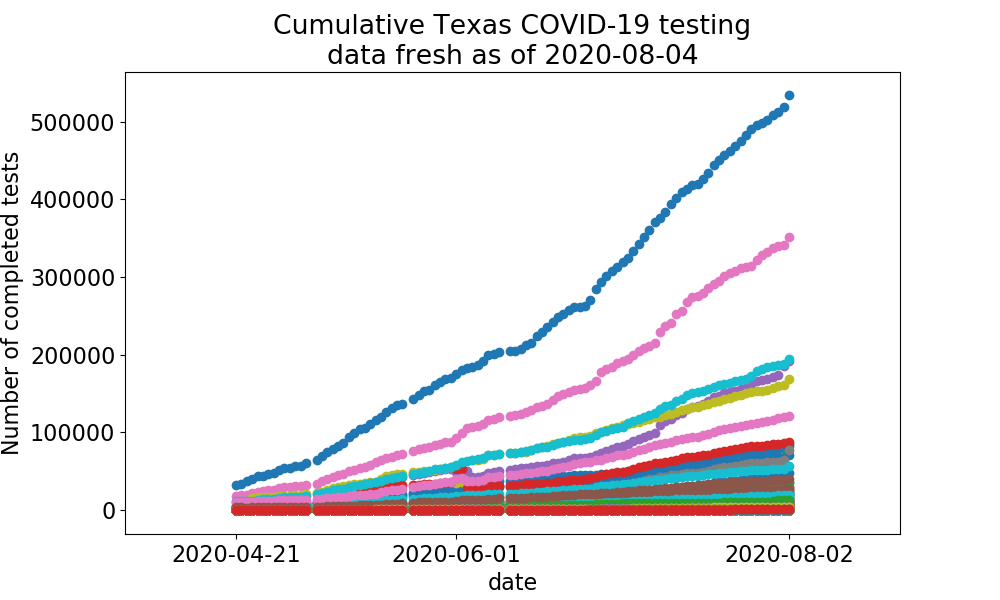

([<matplotlib.axis.XTick at 0x7fb807328cd0>,
 <a list of 3 Text xticklabel objects>)

In [44]:
plt.figure()
plt.title("Cumulative Texas COVID-19 testing\ndata fresh as of 2020-08-04")
for county in df.index:
    plt.scatter(df.columns, df.loc[county, :])
plt.xlabel("date")
plt.ylabel("Number of completed tests")
plt.xticks([df.columns[0], "2020-06-01", "2020-08-02"])

This plot is interesting, but it is a bit unreadable. Let's restrict our data to the top 5 counties which have completed the most tests using Pandas' builtin "sort_values" function.

In [ ]:
# sort rows in descending order according to the cumulative number of
# tests conducted on the most recent day:
df = df.sort_values(by="2020-08-02", ascending=False) 

# keep the first five rows:
top5 = df.iloc[:5] 
top5

We can clearly see that the top five Texas counties in terms of testing are Harris, Dallas, Tarrant, Bexar, and Fort Bend (as of August 4). 

In [ ]:
top5.loc[:, "2020-08-02"]

Let's plot the top 5 counties' cumulative testing over time.

In [ ]:
plt.figure()
plt.title("Cumulative Texas COVID-19 testing\nin the top 5 counties")
for county in top5.index:
    plt.scatter(top5.columns, top5.loc[county, :], label=county)
plt.grid()
plt.legend()
plt.xlabel("date")
plt.ylabel("Number of completed tests")